In [3]:
%load_ext autoreload
%autoreload 2

#### Select Test set

In [4]:
from os import listdir
from os.path import join

do_CEPH = True
vvv_path = "/home/shared/astro/VVV/"

if do_CEPH:
    test_set_path = join(vvv_path, "test_sets/CEPH/time_series")
    file_list = [file[:-4] for file in listdir(test_set_path) if file[-4:] == '.dat' and not (file[0] == '.')]
else:
    test_set_path = join(vvv_path, "test_sets/RRL/zzinntiles_s8_files")
    file_list = [file[:-4] for file in listdir(test_set_path) if file[-4:] == '.dat' and not (file[0] == '.')]


from itertools import zip_longest 
def grouper(iterable, chunk_size, fillvalue=None):
    """
    Receives an iterable object (i.e. list) and a chunk size
    
    Returns an iterable object with the same elements on of the original but arranged in chunks 
    """
    args = [iter(iterable)] * chunk_size
    return zip_longest(*args, fillvalue=fillvalue)

list(grouper(file_list[:10], 3))

[('b347_312_95203', 'b334_515_31798', 'b322_108_92190'),
 ('b336_201_4722', 'b335_404_68201', 'b327_404_35680'),
 ('b326_215_18976', 'b321_416_55117', 'b347_201_5968'),
 ('b329_604_10232', None, None)]

#### Do computation

In [7]:
import time
from joblib import Parallel, delayed, dump
from functools import partial
from features_FATS import read_light_curve, compute_features 

compute_features_test = partial(compute_features, data_path=test_set_path)

tinit = time.time()
result = Parallel(n_jobs=10)(delayed(compute_features_test)(batch_names) for batch_names in grouper(file_list[:1000], 100))
print("Total time [minutes]:", (time.time() - tinit)/60.)

with open(join(vvv_path, "features/features_test_set_%s.pkl" %("CEPH" if do_CEPH else "RRL")), "wb") as f:
    dump(result, f)

Total time: [minutes] 0.3538057883580526


#### Test saved file

In [ ]:
from joblib import load

with open(join(vvv_path, "features/features_test_set_%s.pkl" %("CEPH" if do_CEPH else "RRL")), "rb") as f:
    results = load(f)
pd.concat(results).head(5)

#### Inspect light curves

<IPython.core.display.Javascript object>


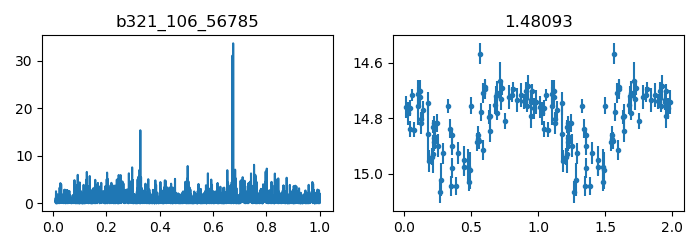

Text(0.5, 1.0, '1.48093')

In [12]:
%matplotlib notebook
import matplotlib.pyplot as plt
import P4J
import numpy as np
from features_FATS import read_light_curve

name = 'b322_408_94452'
#name = 'b351_308_55982'
name = 'b321_106_56785'
#name = 'b341_404_37709'

mjd, mag, err = read_light_curve(join(test_set_path, name+'.dat')).values.T

per  = P4J.periodogram(method='MHAOV')
per.set_data(mjd, mag, err)
per.frequency_grid_evaluation(fmin=0.01, fmax=1., fresolution=1e-4)
#per.frequency_grid_evaluation(fmin=0.001, fmax=10., fresolution=1e-4)

per.finetune_best_frequencies(fresolution=1e-5)
freq, aov = per.get_periodogram()
best_freq = per.get_best_frequency()

fig, ax = plt.subplots(1, 2, figsize=(7, 2.5), tight_layout=True)
ax[0].plot(freq, aov)
phi = np.mod(mjd, 1/best_freq)*best_freq
ax[1].errorbar(np.hstack((phi, phi+1)), np.tile(mag, (2)), np.tile(err, (2)), fmt='.')
ax[1].invert_yaxis()
ax[0].set_title(name)
ax[1].set_title("%0.5f" % (1/best_freq))

In [ ]:
1/(best_freq + 1)

In [ ]:
1/(1/1.37732+1)